In [371]:
from data_cleaning.helper_functions import Sample, save_table
from tslearn.datasets import CachedDatasets
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from dtaidistance import dtw, clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from sklearn.manifold import spectral_embedding
from sklearn.metrics import normalized_mutual_info_score,adjusted_mutual_info_score,mutual_info_score
import scipy
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import entropy
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model
from sklearn import datasets
from sklearn.linear_model import lasso_path, Lasso
from sklearn.metrics import precision_score, recall_score, fbeta_score, multilabel_confusion_matrix
%matplotlib inline
os.chdir("D:\PyCharm\mvts_fss_ay")
os.getcwd()

'D:\\PyCharm\\mvts_fss_ay'

In [436]:
f1_score_models = {}
auc_score_models = {}
acc_score_models = {}
def plot_roc_cm(model_name,cm,n_classes, fpr, tpr, roc_auc,class_report_df,average = "micro"):

  fig,ax = plt.subplots(1,3,figsize=(25,6))
  if average == "micro":
    
    ax[2].plot(fpr['avg / total'], tpr['avg / total'],
        label='micro-average ROC curve (area = {0:0.2f})'
              ''.format(roc_auc['avg / total']),
        color='violet', linestyle='-', linewidth=4)

  else:
    
    ax[2].plot(fpr[average], tpr[average],
        label='macro-average ROC curve (area = {0:0.2f})'
              ''.format(roc_auc['avg / total']),
        color='violet', linestyle='-', linewidth=4)

  # plt.plot(fpr["macro"], tpr["macro"],
  #         label='macro-average ROC curve (area = {0:0.2f})'
  #               ''.format(roc_auc["macro"]),
  #         color='orange', linestyle=':', linewidth=4)
  lw = 2
  colors = cycle(['red', 'green', 'blue','purple','orange'])
  mapping= {
      0: 'H',
      1:'S1',
      2: 'S2',
      3: 'S3',
      4: 'S4'
  }
  for i, color in zip(range(n_classes), colors):
      ax[2].plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(mapping[i], roc_auc[i]))
  labels = ['B','C','F','M','X','avg/total']
  sns.heatmap(cm,ax=ax[0],annot=True)
  ax[0].set_title(f"Confusion Matrix for {model_name}")
  ax[0].set_xticklabels(labels[:-1], rotation=45, ha='left',weight='bold',fontsize = 14)
  ax[0].set_yticklabels(labels[:-1], rotation=45, ha='right',weight='bold',fontsize = 14)
  sns.heatmap(class_report_df.iloc[:,:].drop(['support','pred'],axis=1),annot=True,ax=ax[1])
  ax[1].set_title(f'Classificaton report for {model_name}')

  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='left',weight='bold',fontsize = 12)
  ax[1].set_yticklabels(labels, rotation=45, ha='right',weight='bold',fontsize = 14)
  # ax[1].set_xticklabels(rotation=45)
  # ax[1].set_yticklabels(rotation=45, weight = 'bold')
  ax[2].plot([0, 1], [0, 1], 'k--', lw=lw)
  ax[2].axis(xmin=0.0,xmax=1,ymin=0,ymax=1.05)
  
  ax[2].set_xlabel('False Positive Rate',weight='bold',fontsize = 14)
  ax[2].set_ylabel('True Positive Rate',weight='bold',fontsize = 14)
  ax[2].set_title(f'ROC Curve for {model_name}')
  ax[2].legend(loc="lower right")
  ax[2].set_xticklabels(ax[2].get_xticklabels(),weight='bold',fontsize = 10)
  ax[2].set_yticklabels(ax[2].get_yticklabels(),weight='bold',fontsize = 10)


def class_report(model_name,y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return
    cm = confusion_matrix(y_true, y_pred)
    
    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score','support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            
            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        ac_score = (cm.diagonal()/cm.sum(axis=1)).tolist()
        
        class_report_df['Accuracy'] = pd.Series(ac_score)
        class_report_df.loc['avg / total','Accuracy'] = accuracy_score(y_true,y_pred)
        np.append(ac_score,accuracy_score(y_true,y_pred))
        class_report_df['Accuracy']  = pd.Series(ac_score)
        class_report_df['AUC'] = pd.Series(roc_auc)
        
    
        for score in ac_score:
          print(score)

#     print(accuracy_score(y_true,y_pred))
#     plot_roc_cm(model_name,cm,n_classes,fpr,tpr,roc_auc,class_report_df,average)
    class_report_df.index = ['B','C','F','M','X','avg/total']
    return class_report_df

def kfold(model,n_splits,X,y):
  kf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=0)
  cv_score_auc =[]
  cv_score_f1 = []
  i=1
  for train_index,test_index in kf.split(X,y):
      
      xtr,xvl = X[train_index],X[test_index]
      ytr,yvl = y[train_index],y[test_index]
      
      #model
      model.fit(xtr,ytr)
      score_auc = roc_auc_score(yvl,model.predict_proba(xvl),multi_class='ovr',average='macro')
      score_f1 = f1_score(yvl,model.predict(xvl),average='macro')
      # print('ROC AUC score:',score_auc)
      # print('F1 score: ', score_f1)
      cv_score_auc.append(score_auc)
      cv_score_f1.append(score_f1)
      # pred_test = lr.predict_proba(X_test)[:,1]
      # pred_test_full +=pred_test
      i+=1

  return cv_score_f1, cv_score_auc

def grid_search(estimator, params, X_train,y_train,cv=10):
  grid = GridSearchCV(estimator=estimator, param_grid=params, cv=cv, refit = True)
  grid.fit(X_train, y_train)
  print(f'Best params : {grid.best_params_}')
  print(f'Best score: {grid.best_score_}')

In [31]:
class PIE_RANK:
    def __init__(self, flare_path, non_flare_path):
        self.flare_path = flare_path
        self.non_flare_path = non_flare_path
        self.mapping = {
            "B": 0,
            "C": 1,
            "F": 2,
            "M": 3,
            "X": 4
        }
    
    def __get_column_mapping(self):
        s1 = list(Sample("FL",files_flare[0]).get_data().columns)[:25]
        column_mapping = {}
        for i in range(len(s1)):
            column_mapping[i] = s1[i]
            
        return column_mapping
    
    def generate_flare_set(self):  
        
#         x_count = 10
#         m_count = 10
        files = []
        for file in os.listdir(self.flare_path):
            files.append(file)
#             if file[0] == 'M' and m_count >0:
#                 files.append(file)
#                 m_count-=1
#             elif file[0] == "X" and x_count >0:
#                 files.append(file)
#                 x_count-=1

        return files
    
    def generate_non_flare_set(self):
        b_count = 400
        c_count = 400
        f_count = 400
        files = []
        for file in os.listdir(self.non_flare_path):


            if file[0] == 'B' and b_count > 0:
                files.append(file)
                b_count-=1
            elif file[0] == "C" and c_count > 0:
                files.append(file)
                c_count-=1

            elif file[0] == "F" and f_count > 0:
                files.append(file)
                f_count-=1


        return files
    
    def get_embed_matrix(self,timeseries):
        ds = dtw.distance_matrix_fast(timeseries)
        ds = np.nan_to_num(ds)
        A = kneighbors_graph(ds, 5, mode='connectivity', include_self=True)
        A = 0.5* (A + A.T)
        adj = A.todense()
        np.fill_diagonal(adj,0)
        A = scipy.sparse.csr_matrix(adj)
        G = nx.Graph(A)
        adj = nx.adjacency_matrix(G)
        embed = spectral_embedding(adj,1)
        return embed.flatten()
    
    def relevance_score(self,embed,y):
        mututal_information = mutual_info_score(y,embed)
        entropy_embed = entropy(embed)
        entropy_y = entropy(y)
        relevance_score = mututal_information / (np.sqrt(entropy_embed*entropy_y))
        return relevance_score
    
    def get_score(self):
        files_flare = self.generate_flare_set()
        files_non_flare = self.generate_non_flare_set()
        timeseries = []
        y = []
        scores = {}
        column_mapping = self.__get_column_mapping()
        for col in tqdm(range(1,25)):
            for file in tqdm(files_flare):
                s = Sample("FL",file).get_data().iloc[:,col].values
                y.append(self.mapping[file[0]])
                timeseries.append(s)

            for file in tqdm(files_non_flare):
                s = Sample("NF",file).get_data().iloc[:,col].values
                y.append(self.mapping[file[0]])
                timeseries.append(s)
            embed = self.get_embed_matrix(timeseries)

            kmeans = KMeans(n_clusters=5, random_state=0).fit(embed.reshape(-1,1))
            embed_y = kmeans.labels_.flatten()
            y = np.array(y).flatten()
            scores[column_mapping[col]]= self.relevance_score(embed_y,y)
            timeseries = []
            y = []
        scores_data = pd.DataFrame.from_dict(scores,orient='index',columns=['Relevance Score']).sort_values(by='Relevance Score', ascending=False)
        return scores_data
    

In [32]:
path_FL = os.path.join(os.getcwd(),"data\\partition1\\FL")
path_NF = os.path.join(os.getcwd(),"data\\partition1\\NF")
pie_rank = PIE_RANK(path_FL,path_NF)

In [33]:
files_flare = pie_rank.generate_flare_set()
files_non_flare = pie_rank.generate_non_flare_set()

In [34]:
len(files_flare), len(files_non_flare)

(1254, 1200)

In [35]:
scores_data = pie_rank.get_score()
scores_data

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

,Relevance Score
TOTUSJH,0.066884
TOTPOT,0.057785
USFLUX,0.053885
TOTBSQ,0.043961
TOTFZ,0.036307
MEANJZD,0.022402
EPSX,0.019090
R_VALUE,0.018572
TOTUSJZ,0.017281
EPSZ,0.016764


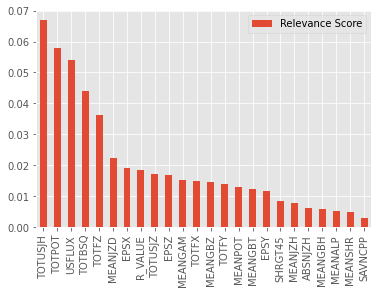

In [39]:

scores_data.plot(kind = 'bar');

In [52]:
save_path = os.path.join(os.getcwd(),"data")
save_path

'D:\\PyCharm\\mvts_fss_ay\\data'

In [48]:
save_table(save_path, pie_rank,"pie_rank_scores", index = True)

# Coordinate descent

In [101]:
def mvts_to_df_embed(path_FL, path_NF):
    pie_rank = PIE_RANK(path_FL,path_NF)
    files_flare = pie_rank.generate_flare_set()
    files_non_flare = pie_rank.generate_non_flare_set()
    mapping = pie_rank.mapping
    timeseries = []
    y = []
    scores = {}
    labels = []
    subset_data = pd.DataFrame(columns = Sample("FL",files_flare[0]).get_data().columns[1:25])
    subset_data['FLARE_CLASS'] = np.nan
    for col in tqdm(range(1,25)):
        for file in tqdm(files_flare):
            s = Sample("FL",file).get_data().iloc[:,col].values


            timeseries.append(s)
            y.append(mapping[file[0]])

        for file in tqdm(files_non_flare):
            s = Sample("NF",file).get_data().iloc[:,col].values
            y.append(mapping[file[0]])

            timeseries.append(s)
        labels.append(y)
        embed = pie_rank.get_embed_matrix(timeseries)
        subset_data.iloc[:,col-1] = embed
        timeseries = []
        y = []
    subset_data.iloc[:,-1] = np.array(labels[0])
    return subset_data

In [102]:
data = mvts_to_df_embed(path_FL, path_NF)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1254 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

## Custom CDL

In [202]:
class Coordinate_Descent_Lasso:
    
    def __init__(self, alpha = 1.0, max_iter = 1000, fit_intercept = False):
        self.alpha = alpha  
        self.max_iter = max_iter
        self.fit_intercept= fit_intercept  
        self.coef_ = None  
        self.intercept_ = None  
        
    def normalize(self, X):
        X = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)
        return X
    def _soft_thresholding_operator(self, x, lambda_):
        if x > 0.0 and lambda_ < abs(x):
            return x - lambda_
        elif x < 0.0 and lambda_ < abs(x):
            return x + lambda_
        else:
            return 0.0

    def fit(self, X, y):
        
        X = self.normalize(X)
        
        if self.fit_intercept:
            X = np.column_stack((np.ones(len(X)), X))

        beta = np.zeros(X.shape[1])
        if self.fit_intercept:
            beta[0] = np.sum(y - np.dot(X[:, 1:], beta[1:])) / (X.shape[0])

        for iteration in range(self.max_iter):
            start = 1 if self.fit_intercept else 0
            for j in range(start, len(beta)):
                tmp_beta = beta.copy()
                tmp_beta[j] = 0.0
                r_j = y - np.dot(X, tmp_beta)
                arg1 = np.dot(X[:, j], r_j)
                arg2 = self.alpha * X.shape[0]

                beta[j] = self._soft_thresholding_operator(arg1, arg2) / (X[:, j]**2).sum()

                if self.fit_intercept:
                    beta[0] = np.sum(y - np.dot(X[:, 1:], beta[1:])) / (X.shape[0])

        if self.fit_intercept:
            self.intercept_ = beta[0]
            self.coef_ = beta[1:]
        else:
            self.coef_ = beta

        return self

    def predict(self, X):
        y = np.dot(X, self.coef_)
        if self.fit_intercept:
            y += self.intercept_ * np.ones(len(y))
        return y





In [203]:
def get_selected_columns_custom(X,y,alpha=0.01, max_iter = 1000, fit_intercept = False):
    model = Coordinate_Descent_Lasso(alpha=alpha,max_iter=max_iter,fit_intercept=fit_intercept)
    model.fit(X, y)
    coefs = model.coef_
    importance = np.abs(coefs)
    return coefs, np.array(data.columns[:-1])[importance > 0]

In [233]:
def get_x_and_y(data, normalize=True):
    
    if normalize == True:
        X = StandardScaler().fit_transform(data.iloc[:,:-1].values)
    else:
        X = data.iloc[:,:-1].values
        
    y = data.iloc[:,-1].values
    return X,y

In [205]:
X,y = get_x_and_y(data)
custom_coefs,selected_subset_custom = get_selected_columns_custom(X,y)
selected_subset_custom

array(['TOTBSQ', 'TOTUSJZ', 'ABSNJZH', 'USFLUX', 'MEANPOT', 'MEANSHR',
       'MEANGAM', 'MEANJZH', 'TOTFY', 'MEANJZD', 'TOTFX', 'EPSY', 'EPSX'],
      dtype=object)

## SKLEARN CDL

In [206]:
def get_selected_columns_sklearn(X,y,alpha=0.01,max_iter = 1000,fit_intercept=False):
    

    lasso = Lasso(alpha=alpha,fit_intercept=fit_intercept)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    lasso.fit(X,y)
    coefs = lasso.coef_
    importance = np.abs(coefs)
    return coefs, np.array(data.columns[:-1])[importance > 0]

In [207]:
X,y = get_x_and_y(data)
sklearn_coefs,selected_subset_sklearn = get_selected_columns_sklearn(X,y)
selected_subset_sklearn

array(['TOTBSQ', 'TOTUSJZ', 'ABSNJZH', 'USFLUX', 'MEANPOT', 'MEANSHR',
       'MEANGAM', 'MEANJZH', 'TOTFY', 'MEANJZD', 'TOTFX', 'EPSY', 'EPSX'],
      dtype=object)

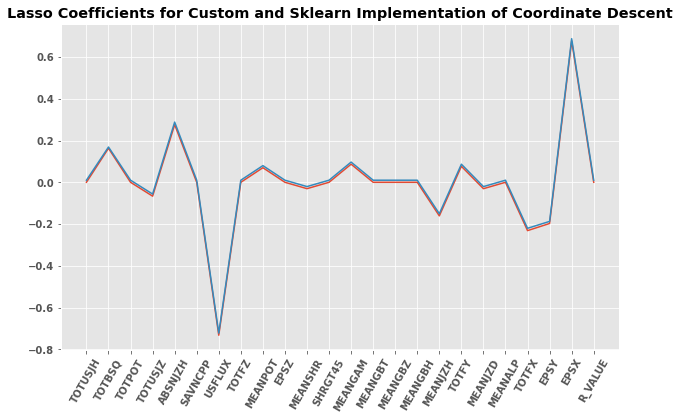

In [649]:
def compare_custom_sklearn(data, custom_coefs,sklearn_coefs):

    plt.figure(figsize = (10,6))
    cols = data.columns[:-1]
    plt.plot(cols,sklearn_coefs, label="Scikit Learn")
    plt.plot(cols,custom_coefs+0.01, label="Custom")
    plt.xticks(rotation = 60,fontweight='bold');
    plt.yticks(fontweight='bold')
    plt.title("Lasso Coefficients for Custom and Sklearn Implementation of Coordinate Descent", fontweight='bold')

compare_custom_sklearn(data, custom_coefs,sklearn_coefs)

In [249]:
def plot_coefficient_path(data):
    X,y = get_x_and_y(data)
    
    fig,ax = plt.subplots(2,1,figsize = (10,10))
    n_alphas = 10
    alphas = np.logspace(-10, 2, n_alphas)
    coefs_scikit_learn = []
    coefs_custom = []
    
    for a in alphas:
        lasso_sklearn = Lasso(alpha=a, fit_intercept=False)
        lasso_sklearn.fit(X, y)
        coefs_scikit_learn.append(lasso_sklearn.coef_)
        

    for a in alphas:
 
        lasso_custom = Coordinate_Descent_Lasso(alpha = a,fit_intercept=False)
        lasso_custom.fit(X,y)
        coefs_custom.append(lasso_custom.coef_)
        
        


    ax[0].plot(alphas, coefs_scikit_learn)
    ax[0].set_title('Lasso coefficient path (Sklearn)',fontweight='bold',fontsize=10)

    ax[1].plot(alphas, coefs_custom)
    ax[1].set_title('Lasso coefficient path (Custom)',fontweight='bold',fontsize=10)
    
    for axes in ax:
        axes.set_xscale('log')
        axes.set_xlabel('Alpha', fontweight='bold',fontsize=8)
        axes.set_ylabel('Coefficients',fontweight='bold',fontsize=8)
        

    plt.axis('tight')    
    plt.legend(data.columns[:-1], bbox_to_anchor = (1.05,1.05))
    

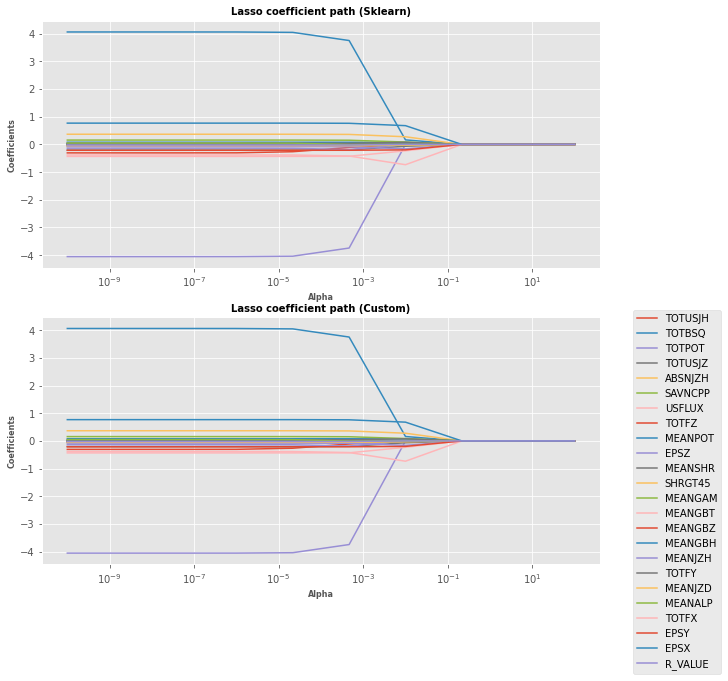

In [250]:
plot_coefficient_path(data)

In [290]:
X, y = get_x_and_y(data,normalize=False)
coefs_1,get_selected_columns_1 = get_selected_columns_custom(X,y,0.0001)
coefs_2,get_selected_columns_2 = get_selected_columns_custom(X,y,0.001)
coesfs_3,get_selected_columns_3 = get_selected_columns_custom(X,y,0.01)
coesfs_4,get_selected_columns_4 = get_selected_columns_custom(X,y,0.1)

In [260]:
len(get_selected_columns_1),len(get_selected_columns_2),len(get_selected_columns_3),len(get_selected_columns_4)

(21, 20, 13, 3)

In [329]:
X, y = get_x_and_y(data,normalize=True)
coefs_1,get_selected_columns_1 = get_selected_columns_sklearn(X,y,0.0001)
coefs_2,get_selected_columns_2 = get_selected_columns_sklearn(X,y,0.001)
coesfs_3,get_selected_columns_3 = get_selected_columns_sklearn(X,y,0.01)
coesfs_4,get_selected_columns_4 = get_selected_columns_sklearn(X,y,0.1)

In [330]:
len(get_selected_columns_1),len(get_selected_columns_2),len(get_selected_columns_3),len(get_selected_columns_4)

(21, 20, 13, 3)

In [331]:
scores_data.head()

,Relevance Score
TOTUSJH,0.066884
TOTPOT,0.057785
USFLUX,0.053885
TOTBSQ,0.043961
TOTFZ,0.036307


In [267]:
custom_coefs, sklearn_coefs

(array([ 0.        ,  0.15896039,  0.        , -0.06636306,  0.27841534,
         0.        , -0.73250895,  0.        ,  0.06981719,  0.        ,
        -0.03052007,  0.        ,  0.08678625,  0.        ,  0.        ,
         0.        , -0.16061808,  0.07665279, -0.03067474,  0.        ,
        -0.23044228, -0.19732249,  0.67789884,  0.        ]),
 array([-0.        ,  0.16299076, -0.        , -0.06647801,  0.27617234,
         0.        , -0.73256751,  0.        ,  0.06981438, -0.        ,
        -0.03056043, -0.        ,  0.08674253, -0.        , -0.        ,
        -0.        , -0.16094951,  0.07662067, -0.0306107 , -0.        ,
        -0.23158199, -0.1972612 ,  0.67746247, -0.        ]))

In [274]:
coefficients = pd.DataFrame(index = data.columns[:-1])
coefficients['Scikit-Learn'] = sklearn_coefs
coefficients['Custom'] = custom_coefs + 0.01
coefficients

,Scikit-Learn,Custom
TOTUSJH,-0.000000,0.010000
TOTBSQ,0.162991,0.168960
TOTPOT,-0.000000,0.010000
TOTUSJZ,-0.066478,-0.056363
ABSNJZH,0.276172,0.288415
SAVNCPP,0.000000,0.010000
USFLUX,-0.732568,-0.722509
TOTFZ,0.000000,0.010000
MEANPOT,0.069814,0.079817
EPSZ,-0.000000,0.010000


In [279]:
save_table(save_path, coefficients,"coefficients", index = True)

In [281]:
save_path

'D:\\PyCharm\\mvts_fss_ay\\data'

In [282]:
data.to_csv(os.path.join(save_path,"data.csv"), index=False, header=True)

In [657]:
len(get_selected_columns_1)

21

## Testing

In [297]:
X, y = data.iloc[:,:-1], data.iloc[:,-1]
# X = StandardScaler().fit_transform(X)
coefs_1,get_selected_columns_1 = get_selected_columns_sklearn(X,y,0.0001)
coefs_2,get_selected_columns_2 = get_selected_columns_sklearn(X,y,0.001)
coesfs_3,get_selected_columns_3 = get_selected_columns_sklearn(X,y,0.01)
coesfs_4,get_selected_columns_4 = get_selected_columns_sklearn(X,y,0.1)

In [332]:
X = data.iloc[:,:-1]
X_set_1 = data.loc[:,get_selected_columns_1]
X_set_2 = data.loc[:,get_selected_columns_2]
X_set_3 = data.loc[:,get_selected_columns_3]
X_set_4 = data.loc[:,get_selected_columns_4]

def scale(X):
    return StandardScaler().fit_transform(X)
X = scale(X)
X_set_1 = scale(X_set_1)
X_set_2 = scale(X_set_2)
X_set_3 = scale(X_set_3)
X_set_4 = scale(X_set_4)

X.shape, X_set_1.shape, X_set_2.shape, X_set_3.shape, X_set_4.shape

((2454, 24), (2454, 21), (2454, 20), (2454, 13), (2454, 3))

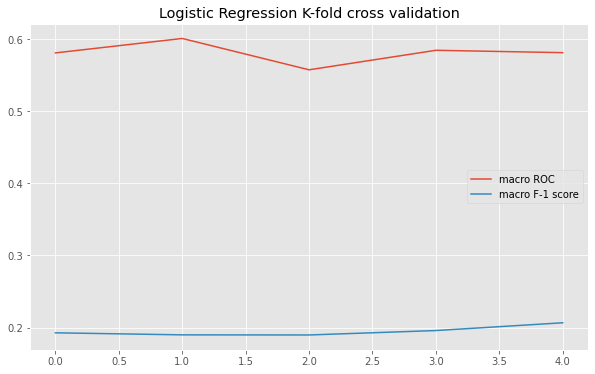

In [333]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,precision_recall_curve,average_precision_score,roc_curve,auc,f1_score,accuracy_score,\
classification_report,multilabel_confusion_matrix, roc_auc_score,precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,LabelEncoder,LabelBinarizer
lr = LogisticRegression(multi_class = 'ovr', penalty = 'l2')
f1_array_log,auc_array_log = kfold(lr, 5, X_set_4, y)
f1_score_models['Logistic Regression'] = np.mean(f1_array_log)
auc_score_models['Logistic Regression'] = np.mean(auc_array_log)
plt.figure(figsize = (10,6))
plt.plot(auc_array_log,label = 'macro ROC');
plt.plot(f1_array_log, label = 'macro F-1 score');
plt.title("Logistic Regression K-fold cross validation")
plt.legend();

In [311]:
f1_array_log

[0.19271089699952873,
 0.18987483058279517,
 0.1897156626506024,
 0.19585185185185186,
 0.20663622526636222]

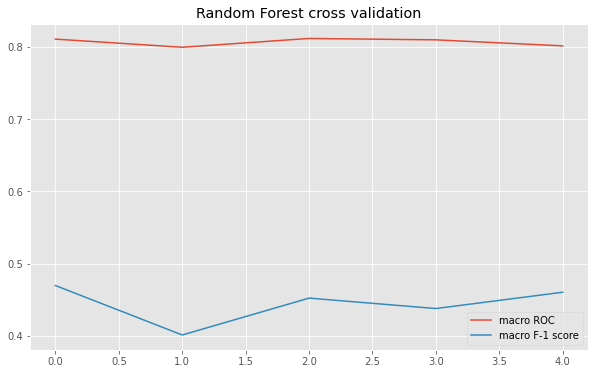

In [334]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier,StackingClassifier
model3 = 'Random Forest'
model3 = RandomForestClassifier(n_estimators=50,criterion='entropy',max_features='log2')
f1_array_rf,auc_array_rf = kfold(model3, 5, X_set_2, y)
f1_score_models['Random Forest'] = np.mean(f1_array_rf)
auc_score_models['Random Forest'] = np.mean(auc_array_rf)
plt.figure(figsize = (10,6))
plt.plot(auc_array_rf,label = 'macro ROC');
plt.plot(f1_array_rf, label = 'macro F-1 score');
plt.title("Random Forest cross validation")
plt.legend();

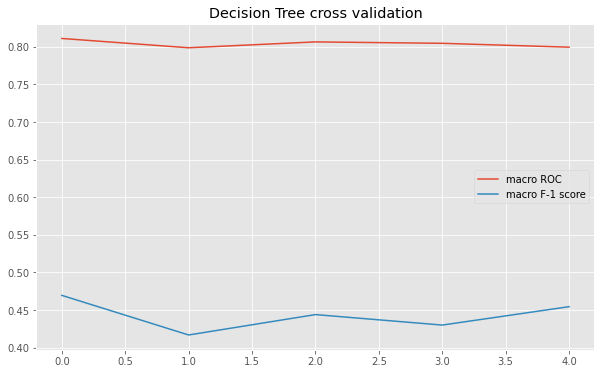

In [316]:
from sklearn.tree import DecisionTreeClassifier
model4 = 'Decision Tree'
model4 = DecisionTreeClassifier(criterion = 'entropy',max_depth = 10, max_leaf_nodes=100)
f1_array_dt,auc_array_dt = kfold(model4, 5, X, y)
f1_score_models['DT'] = np.mean(f1_array_dt)
auc_score_models['DT'] = np.mean(auc_array_dt)
plt.figure(figsize = (10,6))
plt.plot(auc_array_dt,label = 'macro ROC');
plt.plot(f1_array_dt, label = 'macro F-1 score');
plt.title("Decision Tree cross validation")
plt.legend();

In [321]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import svm

In [324]:
classifier = svm.LinearSVC()
classifier.fit(X, y)
y_score = classifier.decision_function(X)
# average_precision = average_precision_score(y, y_score)
# print('Average precision-recall score: {0:0.2f}'.format(
#       average_precision))

In [351]:
def kfold(model,n_splits,X,y):
  kf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=0)
  cv_score_auc =[]
  cv_score_f1 = []
  i=1
  for train_index,test_index in kf.split(X,y):
      
      xtr,xvl = X[train_index],X[test_index]
      ytr,yvl = y[train_index],y[test_index]
      
      #model
      model.fit(xtr,ytr)
      score_auc = precision_score(yvl,model.predict(xvl),average='micro')
      score_f1 = recall_score(yvl,model.predict(xvl),average='micro')
      # print('ROC AUC score:',score_auc)
      # print('F1 score: ', score_f1)
      cv_score_auc.append(score_auc)
      cv_score_f1.append(score_f1)
      # pred_test = lr.predict_proba(X_test)[:,1]
      # pred_test_full +=pred_test
      i+=1

  return cv_score_f1, cv_score_auc


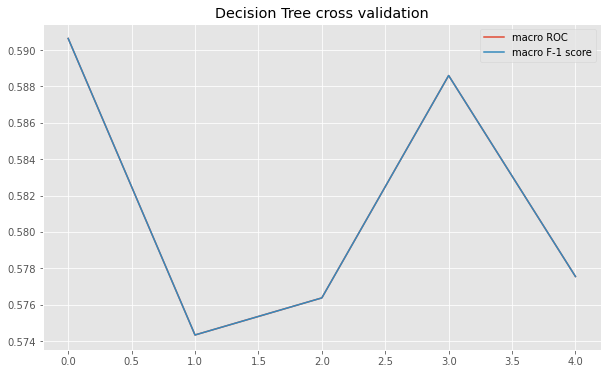

In [352]:
from sklearn.tree import DecisionTreeClassifier
model4 = 'Decision Tree'
model4 = DecisionTreeClassifier(criterion = 'entropy',max_depth = 10, max_leaf_nodes=100)
f1_array_dt,auc_array_dt = kfold(model4, 5, X, y)
f1_score_models['DT'] = np.mean(f1_array_dt)
auc_score_models['DT'] = np.mean(auc_array_dt)
plt.figure(figsize = (10,6))
plt.plot(auc_array_dt,label = 'macro ROC');
plt.plot(f1_array_dt, label = 'macro F-1 score');
plt.title("Decision Tree cross validation")
plt.legend();

In [355]:
y_pred = model4.predict(X)

In [361]:
precision_score(y,y_pred,average="macro"), recall_score(y,y_pred,average="micro"), f1_score(y,y_pred,average="macro")

(0.7813977432209503, 0.5884270578647107, 0.45409427404397434)

In [363]:
y_score = model4.predict_proba(X)
y_score

array([[0.06557377, 0.17486339, 0.        , 0.66120219, 0.09836066],
       [0.06557377, 0.17486339, 0.        , 0.66120219, 0.09836066],
       [0.06557377, 0.17486339, 0.        , 0.66120219, 0.09836066],
       ...,
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.21052632, 0.        , 0.78947368, 0.        , 0.        ]])

array([3, 3, 3, ..., 2, 2, 2])

<AxesSubplot:>

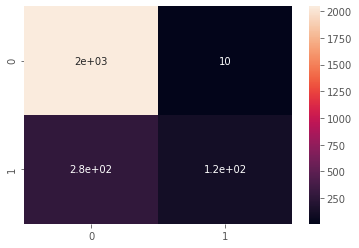

In [380]:
import seaborn as sns
sns.heatmap(multilabel_confusion_matrix(y,y_pred)[0],annot=True)

In [437]:
lol = class_report("lol",y,y_pred).iloc[:,:3]

In [429]:
lol.index = ['B','C','F','M','X','avg/total']

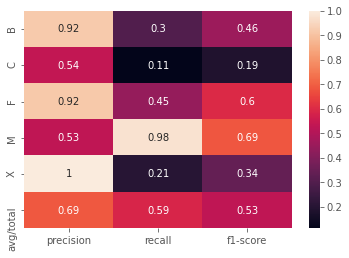

In [438]:
sns.heatmap(lol,annot=True);

In [439]:
lol

,precision,recall,f1-score
B,0.923664,0.302500,0.455744
C,0.535714,0.112500,0.185950
F,0.917526,0.445000,0.599327
M,0.530085,0.978880,0.687742
X,1.000000,0.206061,0.341709
avg/total,0.689904,0.588427,0.530457


In [435]:
 lol.iloc[0,0]

0.9236641221374046

In [533]:
def class_report(model_name,y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return
    cm = confusion_matrix(y_true, y_pred)
    
    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score','support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            
            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        ac_score = (cm.diagonal()/cm.sum(axis=1)).tolist()
        
        class_report_df['Accuracy'] = pd.Series(ac_score)
        class_report_df.loc['avg / total','Accuracy'] = accuracy_score(y_true,y_pred)
        np.append(ac_score,accuracy_score(y_true,y_pred))
        class_report_df['Accuracy']  = pd.Series(ac_score)
        class_report_df['AUC'] = pd.Series(roc_auc)
        
    
        for score in ac_score:
          print(score)

#     print(accuracy_score(y_true,y_pred))
#     plot_roc_cm(model_name,cm,n_classes,fpr,tpr,roc_auc,class_report_df,average)
    class_report_df.index = ['B','C','F','M','X','avg/total']
    return class_report_df

def kfold(model,n_splits,X,y):
    
    kf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=0)
    cv_score_recall =[]
    cv_score_precision = []
    cv_score_f1 = []
    i=1
    for train_index,test_index in kf.split(X,y):
        
        xtr,xvl = X[train_index],X[test_index]
        ytr,yvl = y[train_index],y[test_index]

        #model
        model.fit(xtr,ytr)
        score_precision = precision_score(yvl,model.predict(xvl),average='macro')
        score_recall = recall_score(yvl,model.predict(xvl),average='macro')
        score_f1 = f1_score(yvl,model.predict(xvl),average="macro")
        cv_score_precision.append(score_precision)
        cv_score_recall.append(score_recall)
        cv_score_f1.append(score_f1)
        i+=1

    return cv_score_precision,cv_score_recall,cv_score_f1


## Testing data

In [613]:
X, y = data.iloc[:,:-1], data.iloc[:,-1]
# X = StandardScaler().fit_transform(X)
coefs_1,get_selected_columns_1 = get_selected_columns_sklearn(X,y,0.0001)
coefs_2,get_selected_columns_2 = get_selected_columns_sklearn(X,y,0.001)
coesfs_3,get_selected_columns_3 = get_selected_columns_sklearn(X,y,0.01)
coesfs_4,get_selected_columns_4 = get_selected_columns_sklearn(X,y,0.1)


X = data.iloc[:,:-1]
X_set_1 = data.loc[:,get_selected_columns_1]
X_set_2 = data.loc[:,get_selected_columns_2]
X_set_3 = data.loc[:,get_selected_columns_3]
X_set_4 = data.loc[:,get_selected_columns_4]

def scale(X):
    return StandardScaler().fit_transform(X)
X = scale(X)
X_set_1 = scale(X_set_1)
X_set_2 = scale(X_set_2)
X_set_3 = scale(X_set_3)
X_set_4 = scale(X_set_4)

X.shape, X_set_1.shape, X_set_2.shape, X_set_3.shape, X_set_4.shape

((2454, 24), (2454, 21), (2454, 20), (2454, 13), (2454, 3))

In [560]:
X_set_1.shape

(2454, 21)

In [625]:
precision_B = {}
precision_C = {}
precision_F = {}
precision_M = {}
precision_X = {}
precision_avg = {}

recall_B = {}
recall_C = {}
recall_F = {}
recall_M = {}
recall_X = {}
recall_avg = {}

f1_B = {}
f1_C = {}
f1_F = {}
f1_M = {}
f1_X = {}
f1_avg = {}


precision_score_models_all = {}
recall_scores_models_all = {}
f1_scores_models_all = {}

precision_score_models_3 = {}
recall_scores_models_3 = {}
f1_scores_models_3 = {}

precision_score_models_4 = {}
recall_scores_models_4 = {}
f1_scores_models_4 = {}


## Model definations

In [562]:
from sklearn.neighbors import KNeighborsClassifier
lr = LogisticRegression(multi_class = 'ovr', penalty = 'l2')
knn = KNeighborsClassifier(weights='uniform')
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 10, max_leaf_nodes=100)
rf = RandomForestClassifier(n_estimators=50,criterion='entropy',max_features='log2')

## Precision per sample

### All columns

In [572]:
from sklearn.metrics import precision_recall_fscore_support as score
lr.fit(X,y)
knn.fit(X,y)
dt.fit(X,y)
rf.fit(X,y)
precision_all_lr, recall_all_lr, fscore_all_lr, _ = score(y, lr.predict(X))
precision_all_knn, recall_all_knn, fscore_all_knn, _ = score(y, knn.predict(X))
precision_all_dt, recall_all_dt, fscore_all_dt, _ = score(y, dt.predict(X))
precision_all_rf, recall_all_rf, fscore_all_rf, _ = score(y, rf.predict(X))


# # alpha = 0.01
X = X_set_3
lr.fit(X,y)
knn.fit(X,y)
dt.fit(X,y)
rf.fit(X,y)
precision_3_lr, recall_3_lr, fscore_3_lr, _ = score(y, lr.predict(X))
precision_3_knn, recall_3_knn, fscore_3_knn, _ = score(y, knn.predict(X))
precision_3_dt, recall_3_dt, fscore_3_dt, _ = score(y, dt.predict(X))
precision_3_rf, recall_3_rf, fscore_3_rf, _ = score(y, rf.predict(X))

# # alpha = 0.1
X = X_set_4
lr.fit(X,y)
knn.fit(X,y)
dt.fit(X,y)
rf.fit(X,y)
precision_4_lr, recall_4_lr, fscore_4_lr, _ = score(y, lr.predict(X))
precision_4_knn, recall_4_knn, fscore_4_knn, _ = score(y, knn.predict(X))
precision_4_dt, recall_4_dt, fscore_4_dt, _ = score(y, dt.predict(X))
precision_4_rf, recall_4_rf, fscore_4_rf, _ = score(y, rf.predict(X))




In [570]:
precision_all_lr,precision_all_knn,precision_all_dt, precision_all_rf

(array([0.78333333, 1.        , 0.92857143, 0.5120308 , 0.66666667]),
 array([0.66415094, 0.25669291, 0.70075758, 0.60735171, 0.43010753]),
 array([0.81920904, 0.78      , 0.91752577, 0.52776388, 1.        ]),
 array([0.82446809, 0.78      , 0.91794872, 0.53095118, 1.        ]))

In [603]:
precision_df_all = pd.DataFrame(columns = ['B','C','F','M','X'], index =  ["LR", "KNN", "DT", "RF"])
precision_df_3 = pd.DataFrame(columns = ['B','C','F','M','X'], index =  ["LR", "KNN", "DT", "RF"])
precision_df_4 = pd.DataFrame(columns = ['B','C','F','M','X'], index =  ["LR", "KNN", "DT", "RF"])


recall_df_all = pd.DataFrame(columns = ['B','C','F','M','X'], index =  ["LR", "KNN", "DT", "RF"])
recall_df_3 = pd.DataFrame(columns = ['B','C','F','M','X'], index =  ["LR", "KNN", "DT", "RF"])
recall_df_4 = pd.DataFrame(columns = ['B','C','F','M','X'], index =  ["LR", "KNN", "DT", "RF"])


fscore_df_all = pd.DataFrame(columns = ['B','C','F','M','X'], index =  ["LR", "KNN", "DT", "RF"])
fscore_df_3 = pd.DataFrame(columns = ['B','C','F','M','X'], index =  ["LR", "KNN", "DT", "RF"])
fscore_df_4 = pd.DataFrame(columns = ['B','C','F','M','X'], index =  ["LR", "KNN", "DT", "RF"])




precision_df_all.loc["LR"] =  precision_all_lr
precision_df_all.loc["KNN"] = precision_all_knn
precision_df_all.loc["DT"] =  precision_all_dt
precision_df_all.loc["RF"] =  precision_all_rf


recall_df_all.loc["LR"] =  recall_all_lr
recall_df_all.loc["KNN"] = recall_all_knn
recall_df_all.loc["DT"] =  recall_all_dt
recall_df_all.loc["RF"] =  recall_all_rf


fscore_df_all.loc["LR"] =  fscore_all_lr
fscore_df_all.loc["KNN"] = fscore_all_knn
fscore_df_all.loc["DT"] =  fscore_all_dt
fscore_df_all.loc["RF"] =  fscore_all_rf


"""
3
"""

precision_df_3.loc["LR"] =  precision_3_lr
precision_df_3.loc["KNN"] = precision_3_knn
precision_df_3.loc["DT"] =  precision_3_dt
precision_df_3.loc["RF"] =  precision_3_rf


recall_df_3.loc["LR"] =  recall_3_lr
recall_df_3.loc["KNN"] = recall_3_knn
recall_df_3.loc["DT"] =  recall_3_dt
recall_df_3.loc["RF"] =  recall_3_rf


fscore_df_3.loc["LR"] =  fscore_3_lr
fscore_df_3.loc["KNN"] = fscore_3_knn
fscore_df_3.loc["DT"] =  fscore_3_dt
fscore_df_3.loc["RF"] =  fscore_3_rf



"""
4
"""

precision_df_4.loc["LR"] =  precision_4_lr
precision_df_4.loc["KNN"] = precision_4_knn
precision_df_4.loc["DT"] =  precision_4_dt
precision_df_4.loc["RF"] =  precision_4_rf


recall_df_4.loc["LR"] =  recall_4_lr
recall_df_4.loc["KNN"] = recall_4_knn
recall_df_4.loc["DT"] =  recall_4_dt
recall_df_4.loc["RF"] =  recall_4_rf


fscore_df_4.loc["LR"] =  fscore_4_lr
fscore_df_4.loc["KNN"] = fscore_4_knn
fscore_df_4.loc["DT"] =  fscore_4_dt
fscore_df_4.loc["RF"] =  fscore_4_rf


In [608]:
def savee_table(path, table, table_name, index=False, header=True):
    table.to_csv(os.path.join(path, table_name + ".csv"), index=index, header=header)

In [611]:
path = os.path.join(os.getcwd(),"data")
path

'D:\\PyCharm\\mvts_fss_ay\\data'

In [612]:
savee_table(path,precision_df_all,"precision_df_all",index=True)
savee_table(path,precision_df_3,"precision_df_3",index=True)
savee_table(path,precision_df_4,"precision_df_4",index=True)
savee_table(path,recall_df_all,"recall_df_all",index=True)
savee_table(path,recall_df_3,"recall_df_3",index=True)
savee_table(path,recall_df_4,"recall_df_4",index=True)
savee_table(path,fscore_df_all,"fscore_df_all",index=True)
savee_table(path,fscore_df_3,"fscore_df_3",index=True)
savee_table(path,fscore_df_4,"fscore_df_4",index=True)

## LR

### All columns

In [628]:

def kfold(model,n_splits,X,y):
    
    kf = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=0)
    cv_score_recall =[]
    cv_score_precision = []
    cv_score_f1 = []
    i=1
    for train_index,test_index in kf.split(X,y):
        
        xtr,xvl = X[train_index],X[test_index]
        ytr,yvl = y[train_index],y[test_index]

        #model
        model.fit(xtr,ytr)
        score_precision = precision_score(yvl,model.predict(xvl),average='macro')
        score_recall = recall_score(yvl,model.predict(xvl),average='macro')
        score_f1 = f1_score(yvl,model.predict(xvl),average="macro")
        cv_score_precision.append(score_precision)
        cv_score_recall.append(score_recall)
        cv_score_f1.append(score_f1)
        i+=1

    return cv_score_precision,cv_score_recall,cv_score_f1

# # LR
# ## ALL 
prec, recall, f1 = kfold(lr, 5, X, y)
precision_score_models_all['Logistic Regression'] = np.mean(prec)
recall_scores_models_all['Logistic Regression'] = np.mean(recall)
f1_scores_models_all['Logistic Regression'] = np.mean(f1)

# ## 3
prec, recall, f1 = kfold(lr, 5, X_set_3, y)
precision_score_models_3['Logistic Regression'] = np.mean(prec)
recall_scores_models_3['Logistic Regression'] = np.mean(recall)
f1_scores_models_3['Logistic Regression'] = np.mean(f1)

# ## 4
prec, recall, f1 = kfold(lr, 5, X_set_4, y)
precision_score_models_4['Logistic Regression'] = np.mean(prec)
recall_scores_models_4['Logistic Regression'] = np.mean(recall)
f1_scores_models_4['Logistic Regression'] = np.mean(f1)


# KNN
## ALL
prec, recall, f1 = kfold(knn, 5, X, y)
precision_score_models_all['KNN'] = np.mean(prec)
recall_scores_models_all['KNN'] = np.mean(recall)
f1_scores_models_all['KNN'] = np.mean(f1)

# ## 3
prec, recall, f1 = kfold(knn, 5, X_set_3, y)
precision_score_models_3['KNN'] = np.mean(prec)
recall_scores_models_3['KNN'] = np.mean(recall)
f1_scores_models_3['KNN'] = np.mean(f1)

# ## 4
prec, recall, f1 = kfold(knn, 5, X_set_4, y)
precision_score_models_4['KNN'] = np.mean(prec)
recall_scores_models_4['KNN'] = np.mean(recall)
f1_scores_models_4['KNN'] = np.mean(f1)

# DT
## ALL
prec, recall, f1 = kfold(dt, 5, X, y)
precision_score_models_all['DT'] = np.mean(prec)
recall_scores_models_all['DT'] = np.mean(recall)
f1_scores_models_all['DT'] = np.mean(f1)

## 3
prec, recall, f1 = kfold(dt, 5, X_set_3, y)
precision_score_models_3['DT'] = np.mean(prec)
recall_scores_models_3['DT'] = np.mean(recall)
f1_scores_models_3['DT'] = np.mean(f1)

## 4
prec, recall, f1 = kfold(dt, 5, X_set_4, y)
precision_score_models_4['DT'] = np.mean(prec)
recall_scores_models_4['DT'] = np.mean(recall)
f1_scores_models_4['DT'] = np.mean(f1)

# RF
## ALL
prec, recall, f1 = kfold(rf, 5, X, y)
precision_score_models_all['RF'] = np.mean(prec)
recall_scores_models_all['RF'] = np.mean(recall)
f1_scores_models_all['RF'] = np.mean(f1)

## 3
prec, recall, f1 = kfold(rf, 5, X_set_3, y)
precision_score_models_3['RF'] = np.mean(prec)
recall_scores_models_3['RF'] = np.mean(recall)
f1_scores_models_3['RF'] = np.mean(f1)

## 4
prec, recall, f1 = kfold(rf, 5, X_set_4, y)
precision_score_models_4['RF'] = np.mean(prec)
recall_scores_models_4['RF'] = np.mean(recall)
f1_scores_models_4['RF'] = np.mean(f1)


In [ ]:
# precision_score_models_all = {}
# recall_scores_models_all = {}
# f1_scores_models_all = {}

# precision_score_models_3 = {}
# recall_scores_models_3 = {}
# f1_scores_models_3 = {}

# precision_score_models_4 = {}
# recall_scores_models_4 = {}
# f1_scores_models_4 = {}

In [633]:
precision_score_models_all,precision_score_models_3,precision_score_models_4

({'Logistic Regression': 0.7865881788485902,
  'KNN': 0.47645128569715534,
  'DT': 0.7874478058653075,
  'RF': 0.7803462054890273},
 {'Logistic Regression': 0.599555154927623,
  'KNN': 0.952623412780414,
  'DT': 0.768951812844256,
  'RF': 0.7709852530701031},
 {'Logistic Regression': 0.19897419762575694,
  'KNN': 0.8911530928760211,
  'DT': 0.5872804567397238,
  'RF': 0.5872804567397238})

In [634]:
recall_scores_models_4

{'Logistic Regression': 0.24710706887075634,
 'KNN': 0.873791273834186,
 'DT': 0.2876997850231055,
 'RF': 0.2876997850231055}

In [648]:
results_all = pd.DataFrame(columns = ['Model', 'Precision', 'Recall', 'F-1 Score'])
results_3 = pd.DataFrame(columns = ['Model', 'Precision', 'Recall', 'F-1 Score'])
results_4 = pd.DataFrame(columns = ['Model', 'Precision', 'Recall', 'F-1 Score'])


results_all['Model'] = ['Logistic Regression','KNN','Decision Tree','Random Forest']
results_3['Model'] = ['Logistic Regression','KNN','Decision Tree','Random Forest']
results_4['Model'] = ['Logistic Regression','KNN','Decision Tree','Random Forest']


results_all['Precision'] = list(precision_score_models_all.values())
results_all['Recall'] = list(recall_scores_models_all.values())
results_all['F-1 Score'] = list(f1_scores_models_all.values())

results_3['Precision'] = list(precision_score_models_3.values())
results_3['Recall'] = list(recall_scores_models_3.values())
results_3['F-1 Score'] = list(f1_scores_models_3.values())

results_4['Precision'] = list(precision_score_models_4.values())
results_4['Recall'] = list(recall_scores_models_4.values())
results_4['F-1 Score'] = list(f1_scores_models_4.values())


savee_table(path,results_all,"results_all",index=False)
savee_table(path,results_3,"results_3",index=False)
savee_table(path,results_4,"results_4",index=False)


In [645]:
results_all

,Model,Precision,Recall,F-1 Score
0,Logistic Regression,0.786588,0.353552,0.363633
1,KNN,0.476451,0.430627,0.442744
2,Decision Tree,0.787448,0.404599,0.442969
3,Random Forest,0.780346,0.409916,0.448855


In [646]:
results_3

,Model,Precision,Recall,F-1 Score
0,Logistic Regression,0.599555,0.324042,0.322356
1,KNN,0.952623,0.938411,0.944708
2,Decision Tree,0.768952,0.383384,0.419366
3,Random Forest,0.770985,0.384118,0.419854


In [647]:
results_4

,Model,Precision,Recall,F-1 Score
0,Logistic Regression,0.198974,0.247107,0.194958
1,KNN,0.891153,0.873791,0.881098
2,Decision Tree,0.587280,0.287700,0.277029
3,Random Forest,0.587280,0.287700,0.277029
